In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROOQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq

llm = ChatGroq(model_name="llama-3.1-8b-instant", temperature=0)

result=llm.invoke("Howdy")
result

AIMessage(content='Howdy back atcha. What can I help you with today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 37, 'total_tokens': 52, 'completion_time': 0.016016573, 'prompt_time': 0.00234807, 'queue_time': 0.216644317, 'total_time': 0.018364643}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e32974efee', 'finish_reason': 'stop', 'logprobs': None}, id='run--499caed9-3c5e-457a-8012-fe98ba52d621-0', usage_metadata={'input_tokens': 37, 'output_tokens': 15, 'total_tokens': 52})

In [2]:
def add(a: float, b: float):
    """Adds two numbers."""
    return a + b
def subtract(a: float, b: float):
    """Subtracts two numbers."""
    return a - b
def multiply(a: float, b: float):
    """Multiplies two numbers."""
    return a * b
def divide(a: float, b: float):
    """Divides two numbers."""
    return a / b

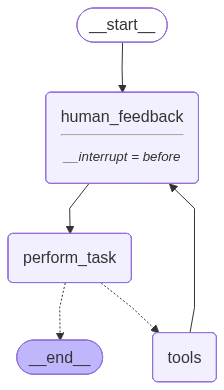

In [3]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image, display

#Bind tools
tools=[add,subtract,multiply,divide]
llm_tool=llm.bind_tools(tools)

# System message prompt
system_message = SystemMessage(content="You are a helpful assistant. You help do a simple arithmetic.")

# ---- Node Function ----
def human_feedback(state: MessagesState):
    pass
def perform_task(state: MessagesState):
    return {"messages":[llm_tool.invoke([system_message] + state["messages"])]}



# ---- Build the Graph ----
builder = StateGraph(MessagesState)

# Nodes 
builder.add_node("perform_task", perform_task)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Edges
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "perform_task")
builder.add_conditional_edges(
    "perform_task", 
    tools_condition,
    )
builder.add_edge("tools", "human_feedback")


# Memory saver
memory = MemorySaver()

# Compile with interrupt_before if needed
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))


In [4]:
import uuid
# ---- thread config ----
config = {
    "configurable": {
        "thread_id": str(uuid.uuid4())  # generates a new, unique thread ID
    }
}


# Initial task
task = {"messages": HumanMessage(content="Add 5 and 6.")}

# Streaming response
for event in graph.stream(task, config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
user_input=input("Please let me know if you want to modify the instruction")
graph.update_state(config,{"messages": user_input}, as_node="human_feedback")
#Continue execution after feedback
for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Add 5 and 6.
================================ Human Message =================================

can you please add 8 and 9
================================== Ai Message ==================================
Tool Calls:
  add (efbr99njd)
 Call ID: efbr99njd
  Args:
    a: 8
    b: 9
================================= Tool Message =================================
Name: add

17.0


In [5]:
#Continue execution to end
for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

17.0
================================== Ai Message ==================================
Tool Calls:
  add (g7q12b1cj)
 Call ID: g7q12b1cj
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11.0
